<a href="https://colab.research.google.com/github/messierandromeda/XAI-Workshop/blob/main/building_multimodal_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Multimodal Pipelines (Image + Text)

In this notebook, we'll build a pipeline that can process and retrieve both **images** and **PDF documents** using the same embedding space. This is powered by CLIP (Contrastive Language-Image Pretraining), which maps both text and images into a shared vector space.

## Requirements
* [Haystack](https://haystack.deepset.ai/) 😎

## Setup Development Environment

Before diving in, let's install the required packages. We'll need:
- **haystack-ai**: The core framework for building AI pipelines and agents
- **pypdf / pypdfium2**: For parsing PDF documents
- **sentence-transformers**: For generating embeddings from text and images

In [1]:
%%bash

pip install -q "haystack-ai>=2.22.0" "sentence-transformers>=4.1.0" pypdf pypdfium2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.7/643.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 7.0 MB/s eta 0:00:00


## Create the Multimodal Indexing Pipeline

First, let's download some sample files to work with:
- An image of an apple 🍎
- An image of a capybara 🦫
- The famous "Attention Is All You Need" paper 📄

📚 Learn more: [Tutorial: Creating Vision+Text RAG Pipelines](https://haystack.deepset.ai/tutorials/46_multimodal_rag)

In [2]:
from urllib.request import URLopener

url_opener = URLopener()
url_opener.addheader("User-Agent", "Mozilla/5.0")

url_opener.retrieve("https://upload.wikimedia.org/wikipedia/commons/2/26/Pink_Lady_Apple_%284107712628%29.jpg?download", "apple.jpg")
url_opener.retrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download", "capybara.jpg")
url_opener.retrieve("https://arxiv.org/pdf/1706.03762", "attention_is_all_you_need.pdf")


('attention_is_all_you_need.pdf', <http.client.HTTPMessage at 0x7cc99e2050d0>)

In [3]:
from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.converters.image import ImageFileToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders.image import SentenceTransformersDocumentImageEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

# Create our document store
doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

# Define our components
file_type_router = FileTypeRouter(mime_types=["application/pdf", "image/jpeg"])
doc_joiner = DocumentJoiner(sort_by_score=False)
image_converter = ImageFileToDocument()
pdf_converter = PyPDFToDocument()
pdf_splitter = DocumentSplitter(split_by="page", split_length=1)
text_doc_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)
image_embedder = SentenceTransformersDocumentImageEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)
document_writer = DocumentWriter(doc_store)


### Construct the Pipeline

Now let's wire up all the components into a pipeline. The flow works like this:

1. **FileTypeRouter** → Routes files based on MIME type (PDF vs image)
2. **PDF path**: Convert → Split by page → Embed with CLIP
3. **Image path**: Convert → Embed with CLIP
4. **DocumentJoiner** → Combines all embedded documents
5. **DocumentWriter** → Stores everything in our document store

In [4]:
indexing_pipe = Pipeline()
indexing_pipe.add_component("file_type_router", file_type_router)
indexing_pipe.add_component("pdf_converter", pdf_converter)
indexing_pipe.add_component("pdf_splitter", pdf_splitter)
indexing_pipe.add_component("image_converter", image_converter)
indexing_pipe.add_component("text_doc_embedder", text_doc_embedder)
indexing_pipe.add_component("image_doc_embedder", image_embedder)
indexing_pipe.add_component("doc_joiner", doc_joiner)
indexing_pipe.add_component("document_writer", document_writer)

indexing_pipe.connect("file_type_router.application/pdf", "pdf_converter.sources")
indexing_pipe.connect("pdf_converter.documents", "pdf_splitter.documents")
indexing_pipe.connect("pdf_splitter.documents", "text_doc_embedder.documents")
indexing_pipe.connect("file_type_router.image/jpeg", "image_converter.sources")
indexing_pipe.connect("image_converter", "image_doc_embedder")
indexing_pipe.connect("text_doc_embedder.documents", "doc_joiner.documents")
indexing_pipe.connect("image_doc_embedder.documents", "doc_joiner.documents")
indexing_pipe.connect("doc_joiner.documents", "document_writer.documents")


🚅 Components
  - file_type_router: FileTypeRouter
  - pdf_converter: PyPDFToDocument
  - pdf_splitter: DocumentSplitter
  - image_converter: ImageFileToDocument
  - text_doc_embedder: SentenceTransformersDocumentEmbedder
  - image_doc_embedder: SentenceTransformersDocumentImageEmbedder
  - doc_joiner: DocumentJoiner
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pdf_converter.sources (list[str | Path | ByteStream])
  - file_type_router.image/jpeg -> image_converter.sources (list[str | Path | ByteStream])
  - pdf_converter.documents -> pdf_splitter.documents (list[Document])
  - pdf_splitter.documents -> text_doc_embedder.documents (list[Document])
  - image_converter.documents -> image_doc_embedder.documents (list[Document])
  - text_doc_embedder.documents -> doc_joiner.documents (list[Document])
  - image_doc_embedder.documents -> doc_joiner.documents (list[Document])
  - doc_joiner.documents -> document_writer.documents (list[Document])

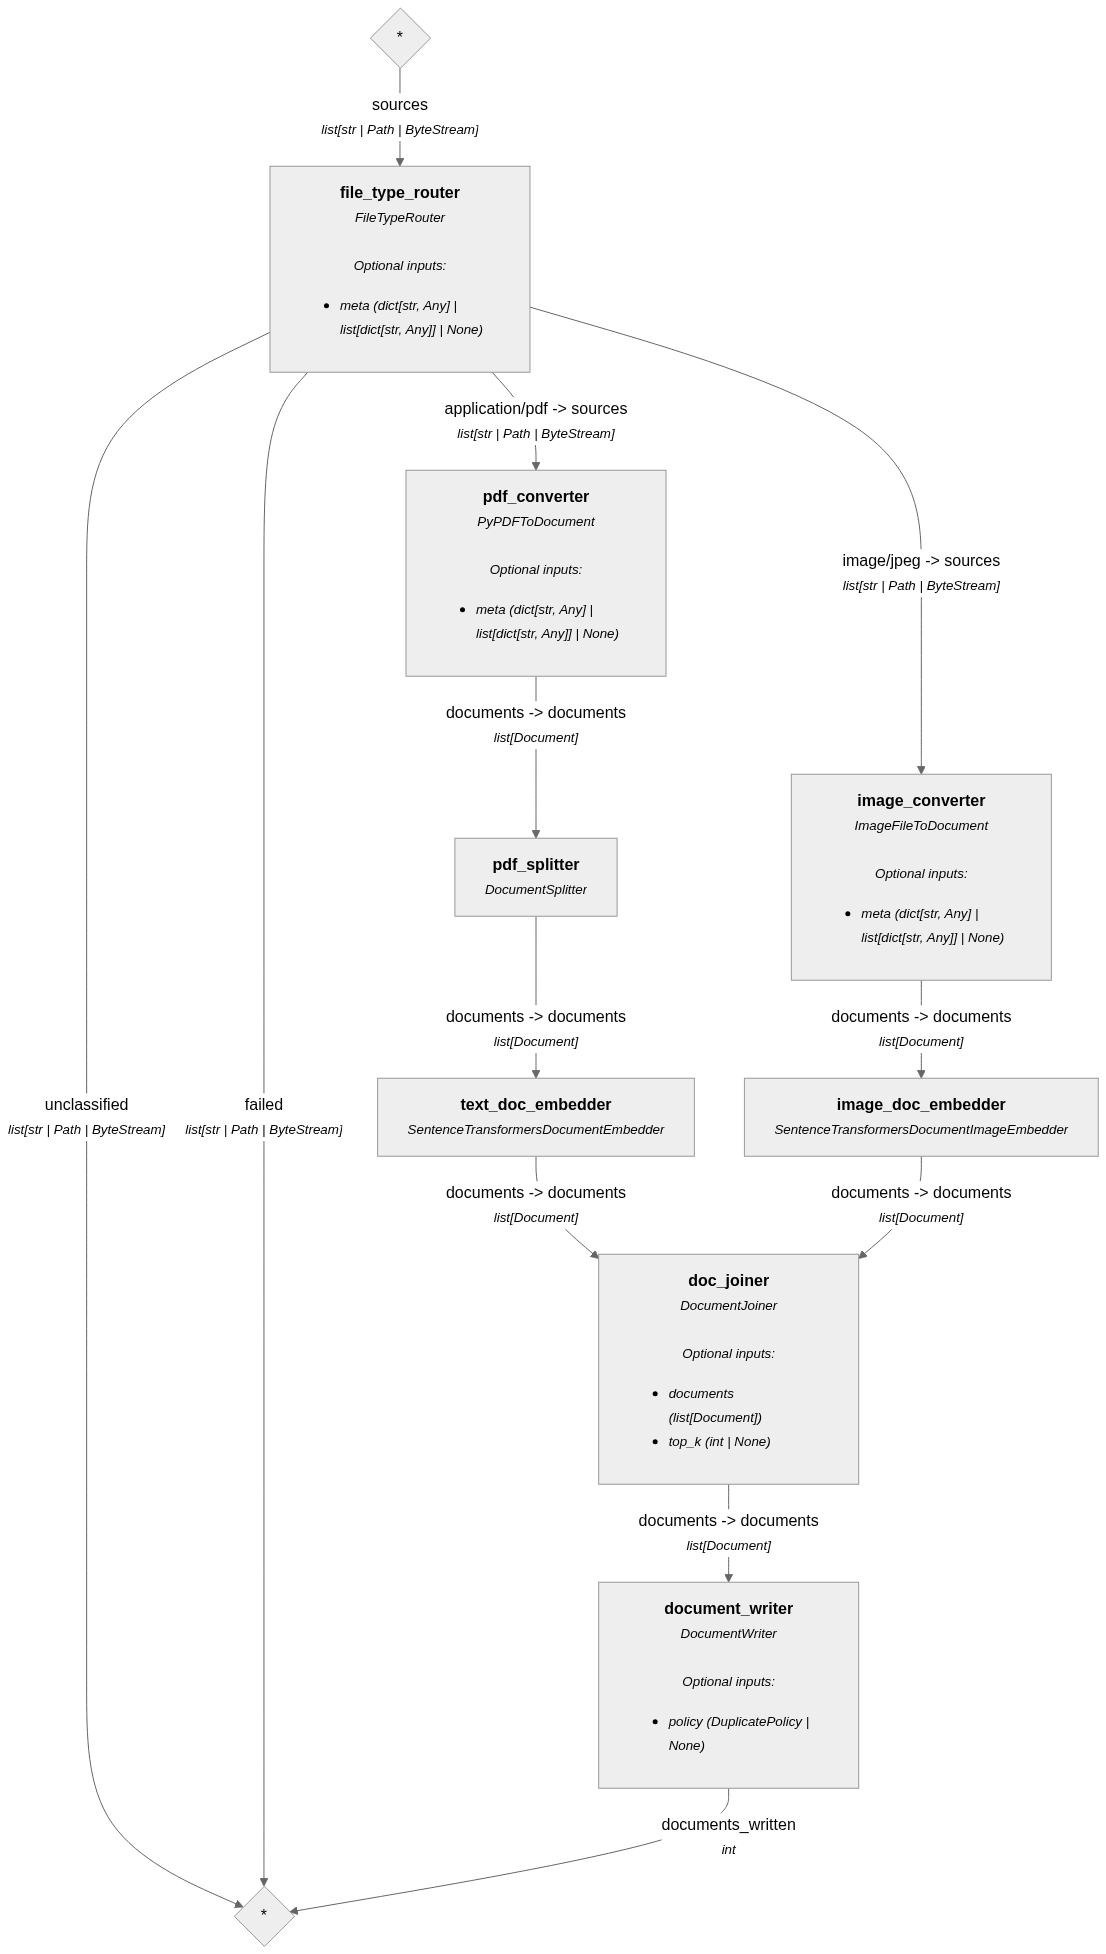

In [5]:
indexing_pipe.show()

### Run the Indexing Pipeline

Let's process our sample files (PDF + images) and store them in the document store. This will embed all documents using the CLIP model so they can be retrieved later.

In [6]:
indexing_result = indexing_pipe.run(
    data={"file_type_router": {"sources": ["attention_is_all_you_need.pdf", "apple.jpg", "capybara.jpg"]}}
)  # create embeddings depending on the data type

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
indexed_documents = doc_store.filter_documents()
print(f"Indexed {len(indexed_documents)} documents")

Indexed 17 documents


## Multimodal Retrieval

In [8]:
# only attention is all you need is retrieved, although we have an apple image....
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/clip-ViT-L-14")
retriever = InMemoryEmbeddingRetriever(document_store=doc_store)  # top_k=5
text_embedding = text_embedder.run(text="An image of an apple")["embedding"]
results = retriever.run(text_embedding)["documents"]

for idx, doc in enumerate(results[:5]):
    print(f"Document {idx+1}:")
    print(f"Score: {doc.score}")
    print(f"File Path: {doc.meta['file_path']}")
    print("")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Document 1:
Score: 0.5757899104027017
File Path: attention_is_all_you_need.pdf

Document 2:
Score: 0.5757899104027017
File Path: attention_is_all_you_need.pdf

Document 3:
Score: 0.5112777276217173
File Path: attention_is_all_you_need.pdf

Document 4:
Score: 0.5000573708763978
File Path: attention_is_all_you_need.pdf

Document 5:
Score: 0.48521761767865046
File Path: attention_is_all_you_need.pdf



Huh, that's odd! When searching for "An image of an apple", the top results are all from the PDF paper — not our apple image. This reveals an important limitation: **not all embedding models are equally good at cross-modal retrieval**.

The CLIP model we used (`clip-ViT-L-14`) is a foundational model but newer, more specialized models often perform better for production use cases.

**Try these alternatives for better multimodal performance:**
- [SentenceTransformersDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentimageembedder) or [JinaDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/jinadocumentimageembedder) → [jina-embeddings-v4](https://huggingface.co/jinaai/jina-embeddings-v4)
- [CohereDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/coheredocumentimageembedder) → [Cohere Embed 4](https://cohere.com/blog/embed-4)
- [AmazonBedrockDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/amazonbedrockdocumentimageembedder) → `amazon.titan-embed-image-v1`, `cohere.embed-english-v3`, `cohere.embed-multilingual-v3`